# Introduction


In [43]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot

from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")

plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [2]:
import yahoo_fin.stock_info as si
ticks = si.tickers_ftse100(True)
sp500 = si.tickers_sp500(True)
dow = si.tickers_dow(True)
nifty = si.tickers_nifty50(True)
display(ticks.head(100))


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


,Company,Ticker,FTSE industry classification benchmark sector[25]
0,3i,III,Financial services
1,Admiral Group,ADM,Insurance
2,Airtel Africa,AAF,Telecommunications services
3,Anglo American plc,AAL,Mining
4,Antofagasta plc,ANTO,Mining
...,...,...,...
95,Vistry Group,VTY,Home Construction
96,Vodafone Group,VOD,Mobile telecommunications
97,Weir Group,WEIR,Industrial goods and services
98,Whitbread,WTB,Retail hospitality


In [21]:
ticks_from_setctors = ticks.groupby('FTSE industry classification benchmark sector[25]',as_index=False).first().iloc[:,[2]]
ticks['FTSE industry classification benchmark sector[25]'].value_counts()

NameError: name 'ticks' is not defined

In [2]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'

In [102]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER

df_dow = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
df_nasdaq = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = NAS_100_TICKER).fetch_data()
df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = HSI_50_TICKER).fetch_data()
df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DAX_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (178733, 8)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['XLNX']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 F

Shape of DataFrame:  (499549, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (261255, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DAI.DE']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 

Shape of DataFrame:  (160570, 8)


In [5]:

df_sp500 = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = SP_500_TICKER).fetch_data()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ABC']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ABMD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******************

$BF.B: possibly delisted; No price data found  (1d 2015-01-01 -> 2024-10-01)


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BHGE']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BLL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[***************

Shape of DataFrame:  (1080081, 8)


In [103]:
df_dow.to_csv('./data/dow.csv')
df_nasdaq.to_csv('./data/nasdaq.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')
df_sp500.to_csv('./data/sp500.csv')



In [3]:
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

In [105]:
df_dow.drop(df_dow.columns[0], axis=1,inplace=True)
df_dow.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.844004,535796800,AAPL,0
1,2000-01-03,70.000000,70.000000,62.875000,44.614418,22914900,AMGN,0
2,2000-01-03,47.995617,47.995617,45.515598,32.671795,6471267,AXP,0
3,2000-01-03,41.437500,41.687500,39.812500,25.940279,2638200,BA,0
4,2000-01-03,23.843750,24.500000,23.843750,12.763931,5055000,CAT,0


In [106]:
ticks_list = df_dow['tic'].unique()

In [107]:
df_copy = df_dow.copy()
df_copy['symbol'] = df_dow['tic']
df_copy.head()
df_close = df_copy[['symbol','close','date']]
df_close.head()

,symbol,close,date
0,AAPL,0.844004,2000-01-03
1,AMGN,44.614418,2000-01-03
2,AXP,32.671795,2000-01-03
3,BA,25.940279,2000-01-03
4,CAT,12.763931,2000-01-03


In [8]:
pivot = df_close.pivot(index='date',values='close',columns='symbol')

pivot.head()

symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.373955,121.188019,80.322266,113.657211,70.367180,58.978180,20.326614,74.213623,86.692467,NaN,...,40.548893,40.232861,42.569790,68.275764,84.473671,86.892952,61.894089,28.402735,53.375530,23.493429
2015-01-05,23.687307,119.747910,78.198082,112.870033,66.652802,57.912903,19.921705,71.247223,85.425591,NaN,...,41.151566,39.862885,41.884403,67.951149,83.456200,85.461685,60.527863,28.166855,52.322048,23.425047
2015-01-06,23.689535,115.889977,76.531540,111.540619,66.223900,56.947189,19.914341,71.214264,84.972481,NaN,...,42.768139,39.277798,41.638020,67.641617,82.711143,85.289261,60.137863,28.451132,52.455502,23.605562
2015-01-07,24.021715,119.937408,78.203003,113.272385,67.250137,56.678383,20.098391,71.154930,85.841728,NaN,...,43.682770,39.776848,42.498112,67.996452,84.121185,86.160080,60.943577,28.267521,53.796913,24.231871
2015-01-08,24.944685,119.505379,79.311516,115.275276,67.939407,58.331051,20.252996,72.783165,86.729439,NaN,...,44.561958,40.946995,43.479137,68.774033,85.867676,90.272797,61.760998,28.873390,54.464100,24.743309


<Axes: xlabel='date'>

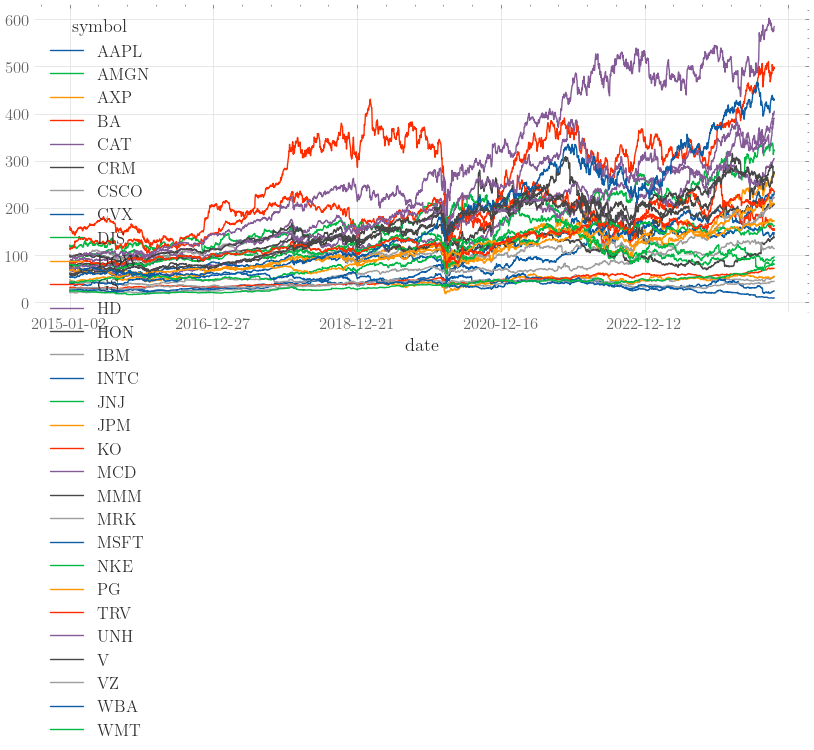

In [40]:
pivot[pivot.index>'2000-01-01'].plot(figsize=(10,4))

In [108]:
df_dax_train = df_dow.copy()
df_dax_train.sort_values(['date','tic'],ignore_index=True,inplace=True)
df_dax_train.index = df_dax_train.index.factorize()[0]

In [109]:
df_dax_train.dropna(inplace=True)
df_dax_train.head()


,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.844004,535796800,AAPL,0
1,2000-01-03,70.000000,70.000000,62.875000,44.614418,22914900,AMGN,0
2,2000-01-03,47.995617,47.995617,45.515598,32.671795,6471267,AXP,0
3,2000-01-03,41.437500,41.687500,39.812500,25.940279,2638200,BA,0
4,2000-01-03,23.843750,24.500000,23.843750,12.763931,5055000,CAT,0


In [4]:
INDICATORS = [
    "close_21_ema",
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed_dax = fe.preprocess_data(df_dax)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


# Env Creation for training and test

In [5]:
train_data_dax = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data_dax = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data_dax.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 19, State Space: 77


In [6]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from agents.evn_mvo import StockPortfolioEnv

stock_dimension = len(train_data_dax.tic.unique())
state_space = stock_dimension
env_kwargs = {
    "initial_amount": 1000000, 
    "normalize_df":None,
    "features" :["close", "high", "low","turbulence",'close_5_ema'],
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = PortfolioOptimizationEnv(df = train_data_dax, **env_kwargs)

In [7]:

stock_dimension = len(train_data_dax.tic.unique())
state_space = stock_dimension
env_kwargs = {
    "initial_amount": 1000000, 
    "normalize_df":None,
    "features" :["close", "high", "low","turbulence",'close_5_ema'],
}


#Establish the training environment using StockTradingEnv() class
est = PortfolioOptimizationEnv(df = test_data_dax, **env_kwargs)

In [120]:
len(est._df.index.unique())

447

# PPO training
### trainin PPO Models on the train set and plotting results

In [25]:

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    metrics_df = None
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"]}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,metrics_df

In [19]:
time_windows = [1,5,21]
results= {}
for i in time_windows:
    results["ppo_"+ str(i)] = {"i" : i}
results

{'ppo_1': {'i': 1}, 'ppo_5': {'i': 5}, 'ppo_21': {'i': 21}}

In [31]:
from finrl.agents.stablebaselines3.models import DRLAgent
time_windows = [1,5,21]
 
results= {}
for i in time_windows:
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }
    e_train_gym = PortfolioOptimizationEnv(df = train_data_dax, **env_kwargs)
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }

    est = PortfolioOptimizationEnv(df = test_data_dax, **env_kwargs)
    agent = DRLAgent(env = e_train_gym)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.0003,
        "batch_size": 128,
    }
    model_ppo = agent.get_model("ppo"
                                ,model_kwargs = PPO_PARAMS)
    ppo_model = agent.train_model(model=model_ppo, 
                                tb_log_name='ppo',
                                total_timesteps=80000)
    metrics_df_dax = pd.DataFrame(
        {
            "date": e_train_gym._date_memory,
            "actions": e_train_gym._actions_memory,
            "returns": e_train_gym._portfolio_return_memory,
            "rewards": e_train_gym._portfolio_reward_memory,
            "portfolio_values": e_train_gym._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(ppo_model, est,i)
    results["ppo_"+ str(i)] = {'train_df': metrics_df_dax,'test_df':ppo_predictions}

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| time/              |            |
|    fps             | 59         |
|    iterations      | 1          |
|    time_elapsed    | 34         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.00711112 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 2           |
|    time_elapsed         | 68          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014155014 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | 0.324      

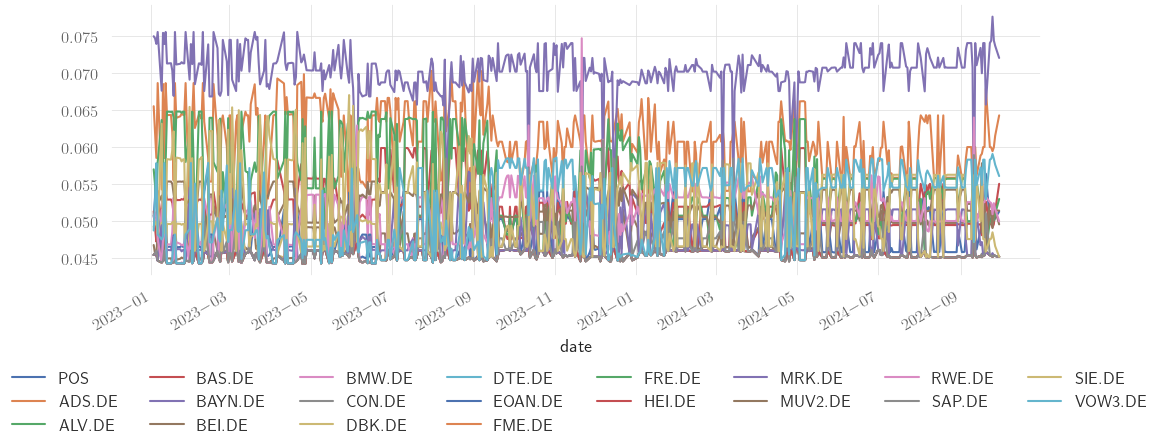

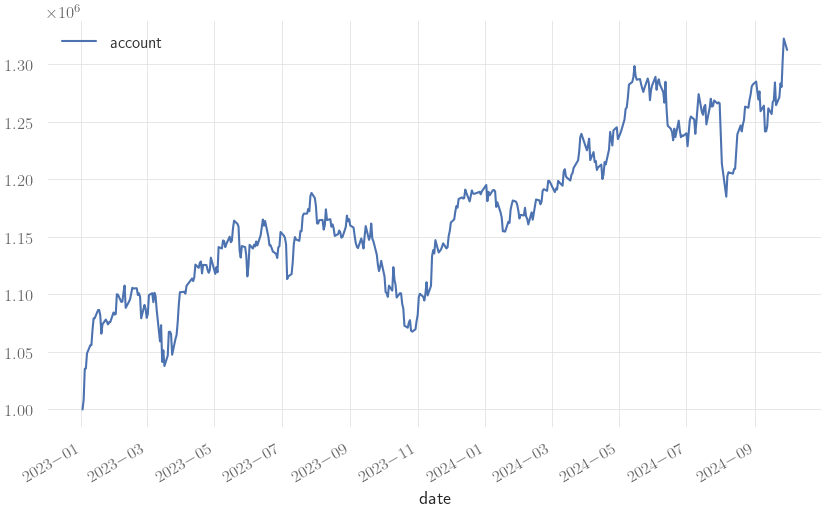

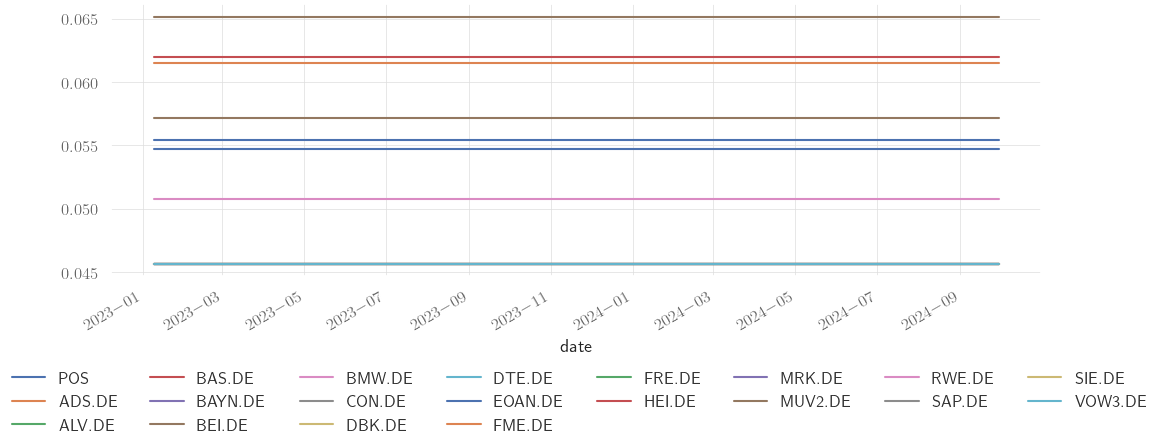

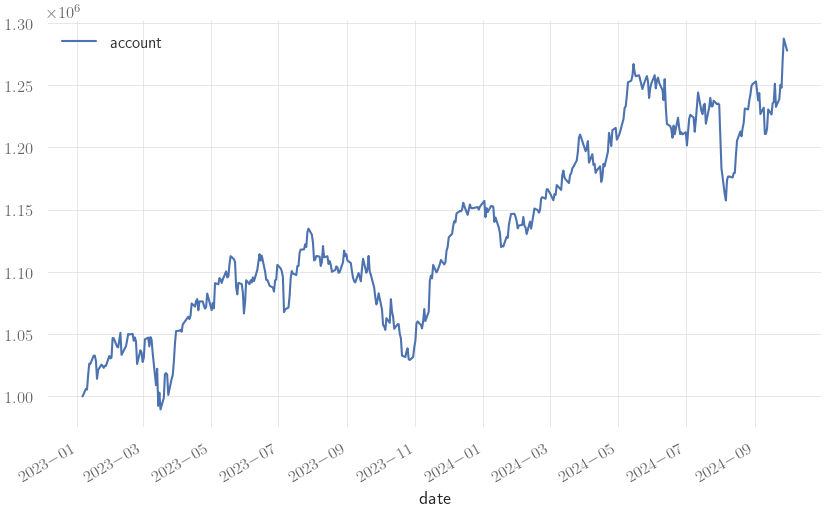

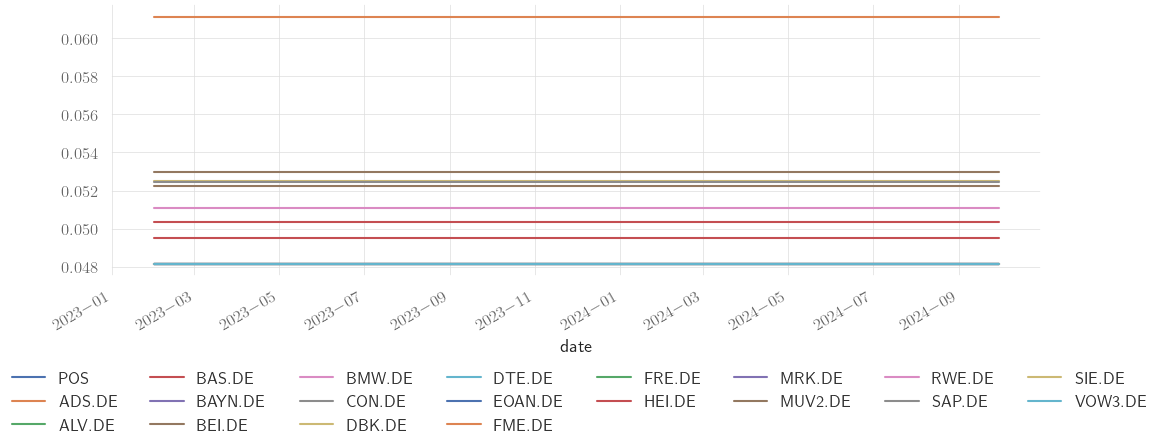

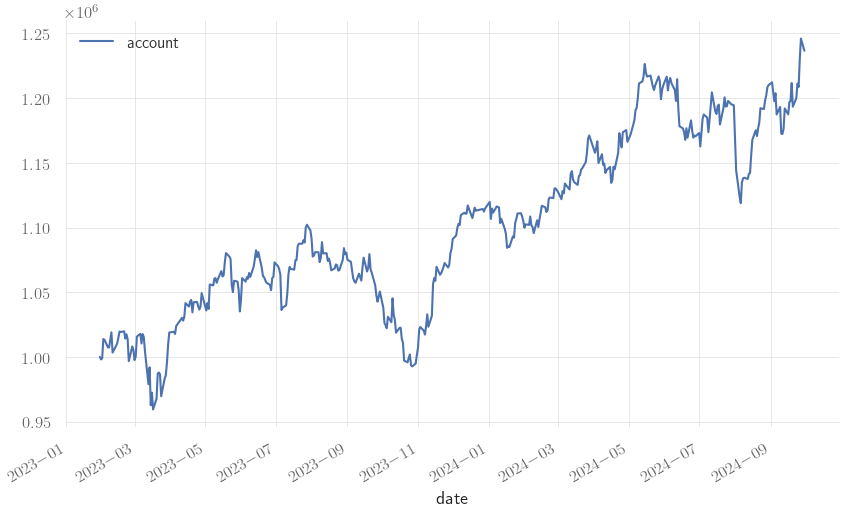

In [38]:
for item in results:    
    results[item]['test_df'][1].iloc[1:,].plot(figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    results[item]['test_df'][0].plot(x='date',y='account')
    

In [45]:
with open('./models/ppo.pkl','wb') as f:
    pickle.dump(results,f)

## Testing PPO on test set

In [14]:
est._actions_memory

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

# Actor Advantage Critic

## Training The Model

In [155]:
a2c_model = agent.get_model("a2c")
trained_a2c = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| time/                 |               |
|    fps                | 25            |
|    iterations         | 100           |
|    time_elapsed       | 19            |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -45.2         |
|    explained_variance | -0.0422       |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | -0.614        |
|    reward             | -0.0008983474 |
|    std                | 1.09          |
|    value_loss         | 0.000213      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 25          |
|    iterations         | 200         |
|    time_elaps

In [47]:
from finrl.agents.stablebaselines3.models import DRLAgent
time_windows = [1,5,21]
 
results= {}
for i in time_windows:
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }
    e_train_gym = PortfolioOptimizationEnv(df = train_data_dax, **env_kwargs)
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }

    est = PortfolioOptimizationEnv(df = test_data_dax, **env_kwargs)
    agent = DRLAgent(env = e_train_gym)
    model_a2c = agent.get_model("a2c")
    a2c_model = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=80000)
    metrics_df_dax = pd.DataFrame(
        {
            "date": e_train_gym._date_memory,
            "actions": e_train_gym._actions_memory,
            "returns": e_train_gym._portfolio_return_memory,
            "rewards": e_train_gym._portfolio_reward_memory,
            "portfolio_values": e_train_gym._asset_memory["final"],
        }
    )
    a2c_predictions = DRL_prediction(a2c_model, est,i)
    results["a2c_"+ str(i)] = {'train_df': metrics_df_dax,'test_df':a2c_predictions}

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| time/                 |               |
|    fps                | 54            |
|    iterations         | 100           |
|    time_elapsed       | 9             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -29.8         |
|    explained_variance | -163          |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | 0.419         |
|    reward             | -0.0033638964 |
|    std                | 1.07          |
|    value_loss         | 0.00288       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 55          |
|    iterations         | 200         |
|    time_elaps

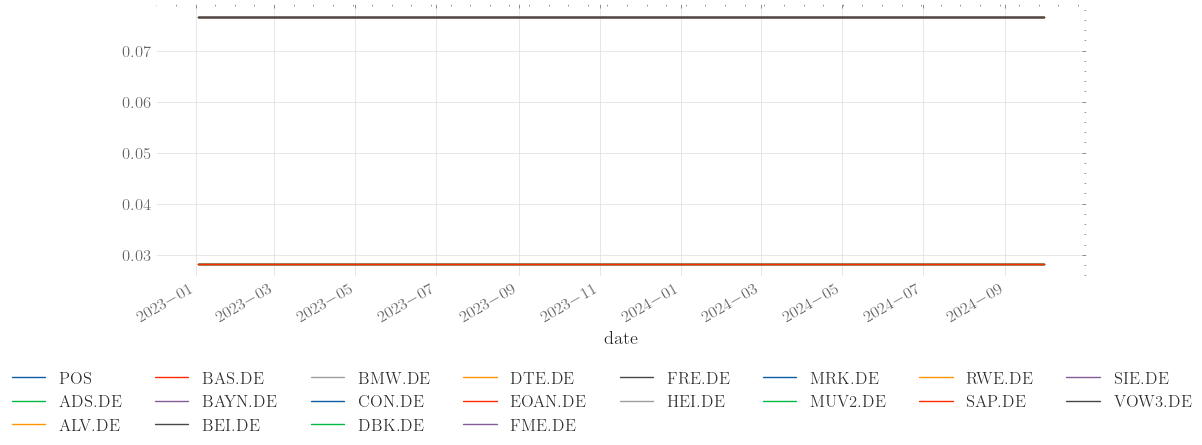

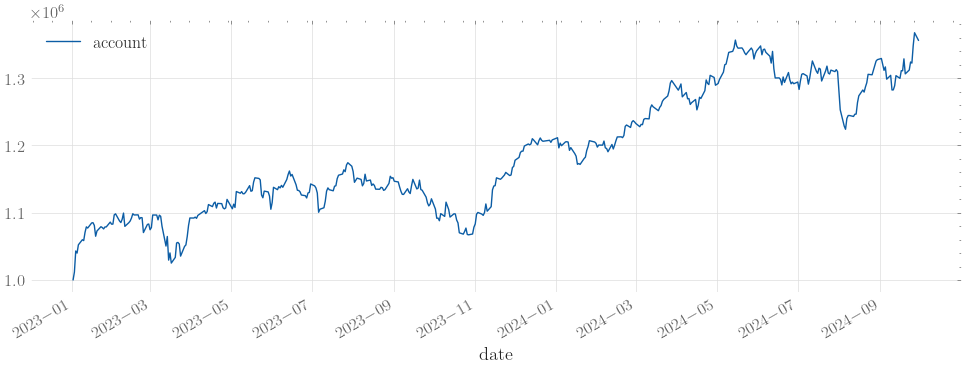

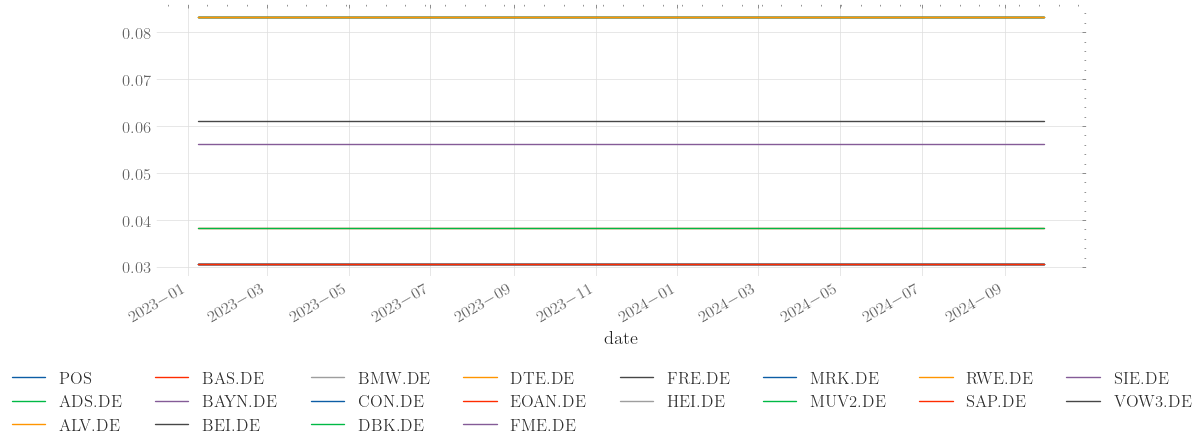

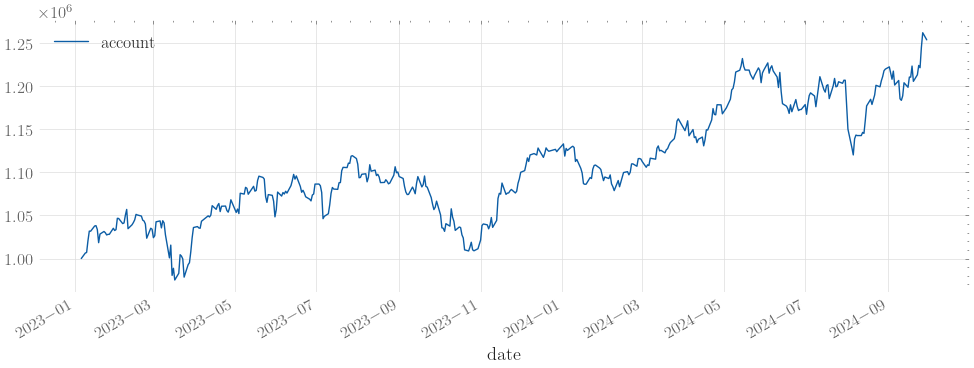

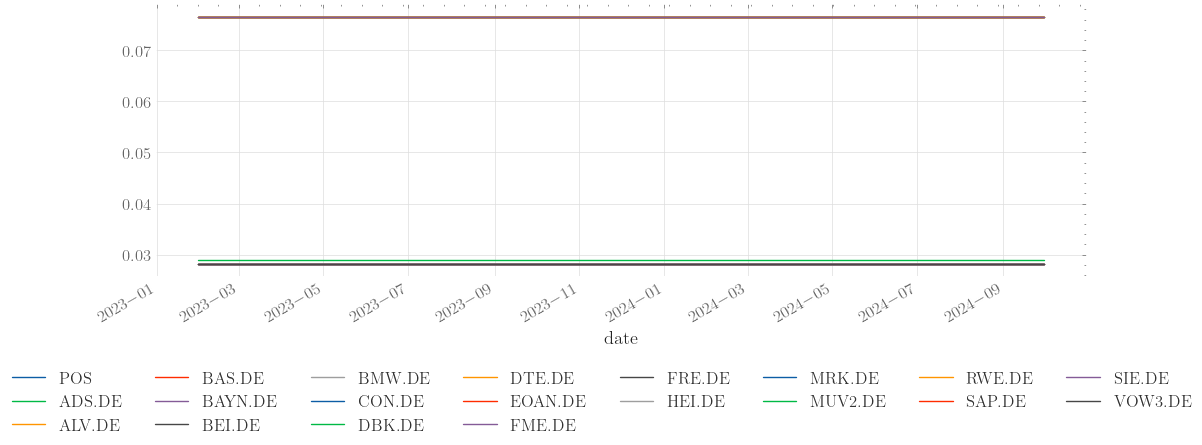

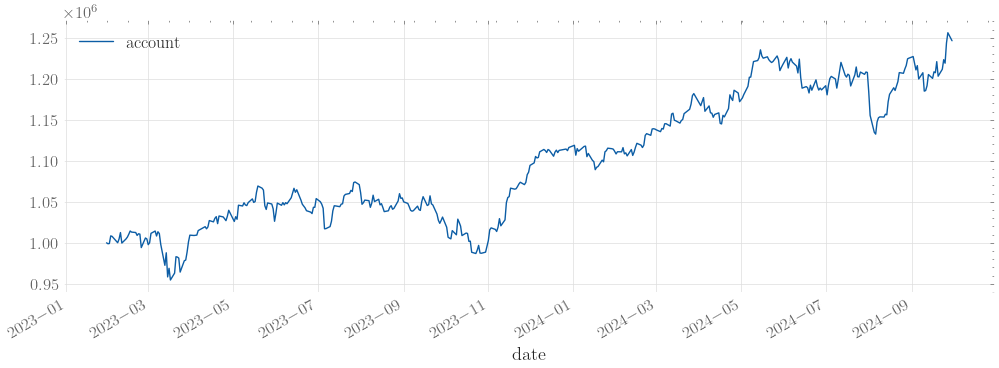

In [50]:
for item in results:    
    results[item]['test_df'][1].iloc[1:,].plot(figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    results[item]['test_df'][0].plot(x='date',y='account',figsize=(12,4))

# Buy and hold strategy

In [26]:
test_data_dax

,Unnamed: 0,date,open,high,low,close,volume,tic,day,close_21_ema,close_5_ema,turbulence
0,63237,2024-01-02,184.199997,186.600006,181.080002,181.666138,376060,ADS.DE,1,187.790171,184.418740,22.650663
0,63238,2024-01-02,242.899994,246.649994,242.699997,232.545197,778095,ALV.DE,1,227.715707,230.461078,22.650663
0,63239,2024-01-02,49.000000,49.474998,48.404999,45.798027,1778922,BAS.DE,1,43.983016,45.492149,22.650663
0,63240,2024-01-02,33.794998,34.445000,33.715000,34.187199,3809729,BAYN.DE,1,33.050808,33.456149,22.650663
0,63241,2024-01-02,136.000000,136.149994,134.550003,134.004425,127940,BEI.DE,1,132.023878,134.012515,22.650663
...,...,...,...,...,...,...,...,...,...,...,...,...
191,68607,2024-09-30,33.090000,33.180000,32.680000,32.680000,1951912,RWE.DE,0,32.420701,32.644584,18.315376
191,68608,2024-09-30,204.550003,207.050003,204.399994,204.399994,1774113,SAP.DE,0,200.903332,204.547943,18.315376
191,68609,2024-09-30,181.259995,183.580002,180.559998,181.339996,1595961,SIE.DE,0,170.486036,178.240275,18.315376
191,68610,2024-09-30,33.000000,33.040001,32.389999,32.730000,2725760,VNA.DE,0,32.126941,32.502375,18.315376


In [45]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data_dax,
    initial_amount=1000000,
    comission_fee_pct=0.0025,
    time_window=5,
    features = ["close", "high", "low",'close_21_ema','close_5_ema','turbulence'],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1125362.125
Final accumulative portfolio value: 1.125362125
Maximum DrawDown: -0.0760090837708215
Sharpe ratio: 1.4687536395597616


In [46]:
buy_and_hold_train = environment_train_buy_and_hold._asset_memory["final"]
buy_and_hold_weights_train = environment_train_buy_and_hold._final_weights
buy_and_hold_weights_df = pd.DataFrame(buy_and_hold_weights_train)
buy_and_hold_account_df = pd.DataFrame(buy_and_hold_train,environment_train_buy_and_hold._date_memory)
buy_and_hold_weights_df.drop(buy_and_hold_weights_df.columns[0],axis=1,inplace=True)
buy_and_hold_weights_df.columns = test_data_dax.tic.unique()



In [30]:
buy_and_hold_weights_df.shape

(192, 26)

In [164]:
bah_dates = environment_train_buy_and_hold._date_memory

In [37]:
buy_and_hold_account_df.head()
buy_and_hold_account_df.columns = ['acc']

In [38]:
buy_and_hold_account_df.head()


,acc
2024-01-02,1000000.0000
2024-01-03,987370.0625
2024-01-04,992802.5625
2024-01-05,990178.6875
2024-01-08,994333.2500


<Axes: >

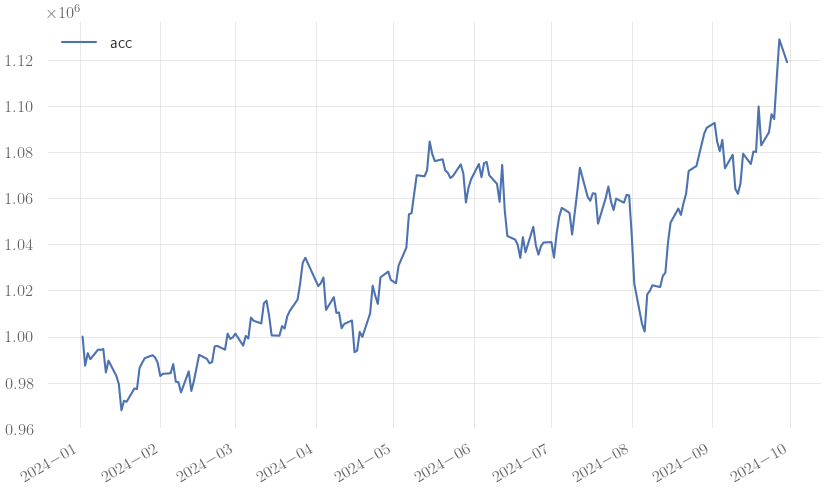

In [42]:
%matplotlib inline

buy_and_hold_account_df.plot()

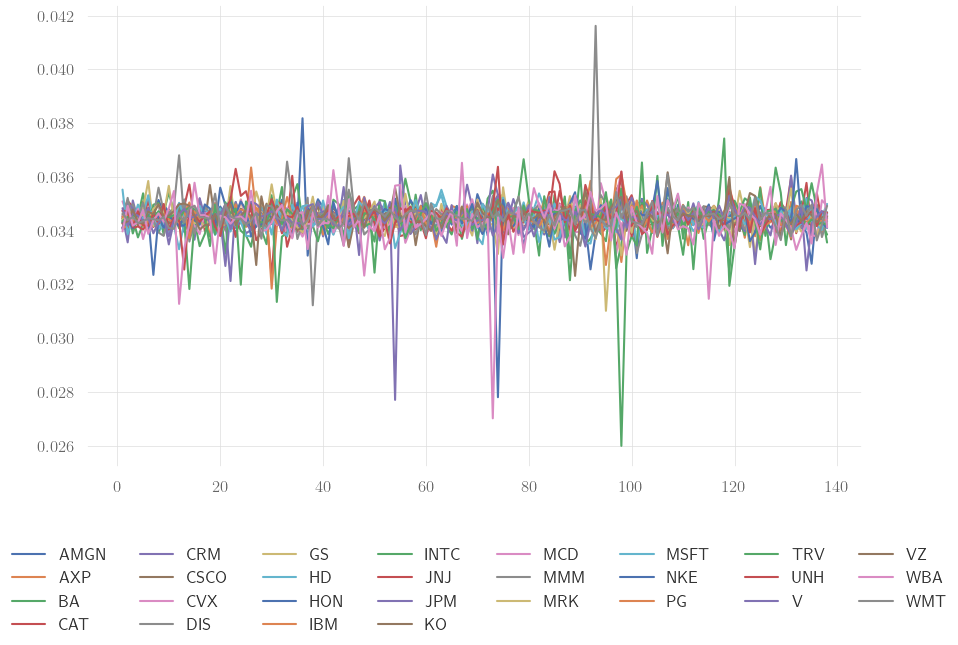

In [77]:
buy_and_hold_weights_df.head()
buy_and_hold_weights_df.iloc[1:,1:].plot().legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

In [18]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

In [19]:
states_ppo = e_train_gym.state_memory
states_ppo_dates = e_train_gym.date_memory
states = np.array(states_ppo)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
total_portfolio_value = holdings.sum(axis=1).reshape(-1, 1)

ppo_weights = holdings /total_portfolio_value
weights_df = pd.DataFrame(ppo_weights, columns=z2.columns[1:stock_dimension + 1].tolist())



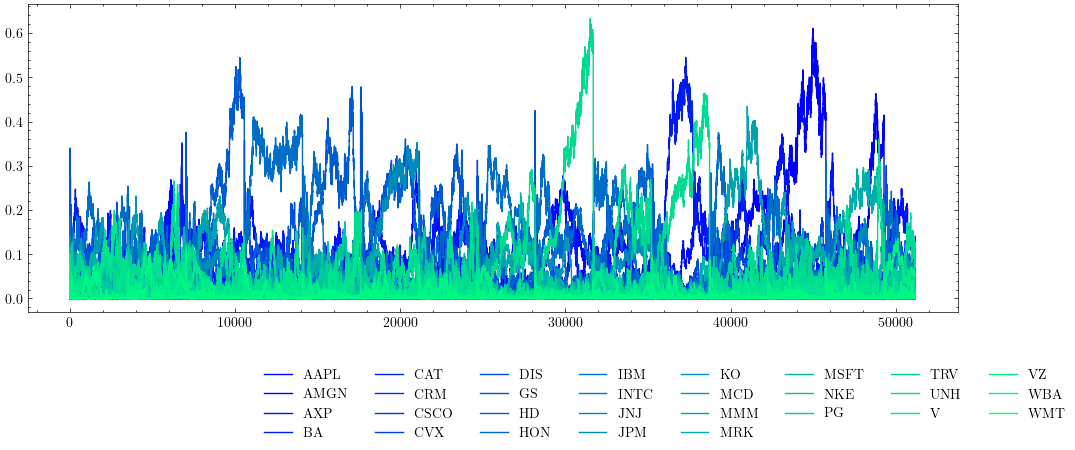

In [32]:
weights_df.plot(colormap="winter",figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

# Mean Variance Optimization
## Data Preaparation

In [57]:
# add covariance matrix as states
df = df_dax.copy()
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

df["pct_change"] = df.groupby("tic").close.pct_change()

cov_list = []
# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(
        index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values
    cov_list.append(covs)


In [58]:
df["mean_pct_change_lookback"] = df.rolling(lookback)["pct_change"].mean()
df["ewm_returns"] = df["pct_change"].ewm(span=50).mean()
df_cov = pd.DataFrame(
    {'time': df.date.unique()[lookback:], 'cov_list': cov_list})
df = df.merge(df_cov, left_on='date',right_on='time')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

In [45]:
df.head(3)

,Unnamed: 0,date,open,high,low,close,volume,tic,day,pct_change,mean_pct_change_lookback,ewm_returns,time,cov_list
0,6611,2015-12-29,33.990002,34.259998,33.855000,26.594761,87800,1COV.DE,1,0.008141,0.004539,-0.002698,2015-12-29,"[[0.00034323932665468194, 7.206369580528994e-0..."
1,6612,2015-12-29,89.790001,91.510002,89.519997,82.582344,598980,ADS.DE,1,0.027164,0.004696,-0.001527,2015-12-29,"[[0.00034323932665468194, 7.206369580528994e-0..."
2,6613,2015-12-29,162.899994,165.000000,162.600006,106.094025,969487,ALV.DE,1,0.021672,0.004869,-0.000618,2015-12-29,"[[0.00034323932665468194, 7.206369580528994e-0..."


# Mean Variance optimization

In [59]:

from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


test_df = data_split(
    df,
    start=TEST_START_DATE,
    end=TEST_END_DATE
)

stock_dimension = len(test_df.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.0025,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}
e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
agent = MarkowitzAgent(e_test_gym)
markowitz_history_df = agent.prediction(e_test_gym)
markowitz_history_df["method"] = "markowitz"

Stock Dimension: 28, State Space: 28
begin_total_asset:1000000
end_total_asset:1390672.48494299
Sharpe:  1.5401882370545639
Test Finished!
episode_return 1.39067248494299


<Axes: xlabel='date'>

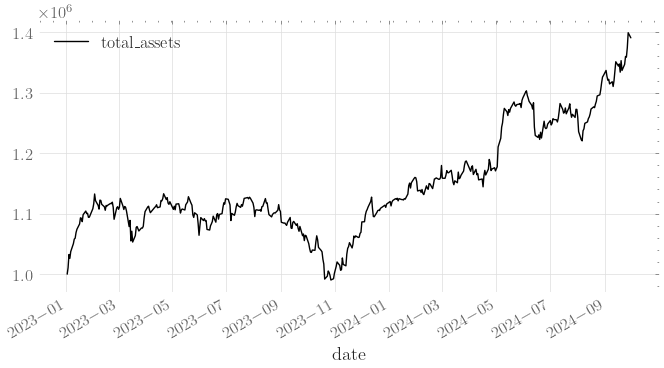

In [60]:
%matplotlib inline
markowitz_history_df.plot.line(x='date', y= 'total_assets',figsize=(8,4),color='black')

# Methods Comparison

## DOW

In [184]:
len(markowitz_history_df.get('date').tolist())

189

In [ ]:
res[0].plot(x='date',y='account')

In [55]:
buy_and_hold_account_df.columns = ['account']
%matplotlib inline


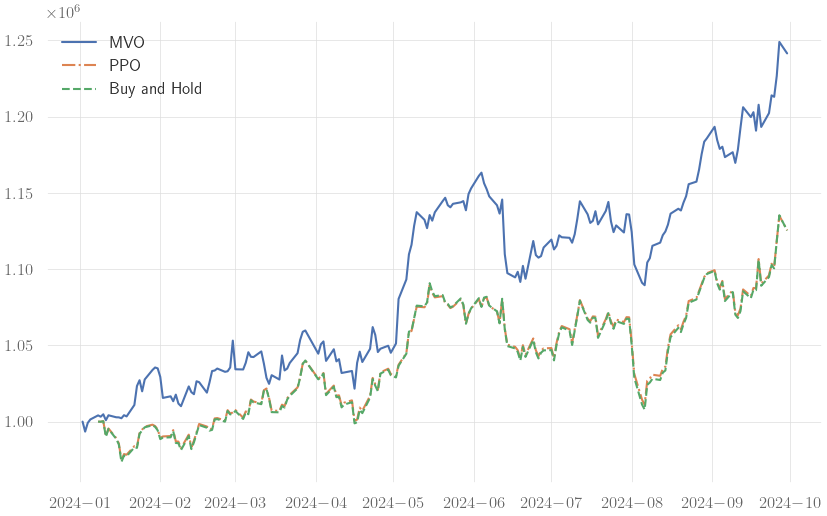

In [65]:
plt.plot(markowitz_history_df.get('date').tolist(), markowitz_history_df.get('total_assets').tolist(), label = "MVO", linestyle="-")
plt.plot(res[0].get('date').tolist(), res[0].get('account').tolist(), label = "PPO", linestyle="-.")
plt.plot(buy_and_hold_account_df.index.values, buy_and_hold_account_df.get('account').tolist(), label = "Buy and Hold", linestyle="--")
plt.legend()
plt.show()

## DAX

AttributeError: 'NoneType' object has no attribute 'tolist'

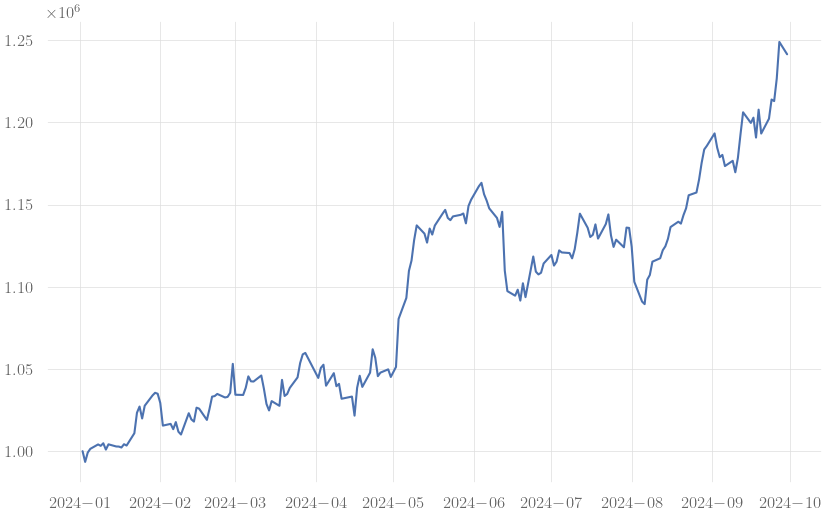

In [144]:
%matplotlib inline
plt.plot(markowitz_history_df.get('date').tolist(), markowitz_history_df.get('total_assets').tolist(), label = "MVO", linestyle="-")
plt.plot(metrics_dax.get('date').tolist(), metrics_dax.get('portfolio_values').tolist(), label = "PPO", linestyle="-.")
plt.plot(markowitz_history_df.iloc[1:,0].values, buy_and_hold_account_df.get('account').tolist(), label = "Buy and Hold", linestyle="--")

plt.title('DAX Performance')
plt.legend()
plt.show()

# Others

In [57]:
from stock_env import StockTradingEnv
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
env_kwargs = {
    "hmax": 100, 
    "num_stock_shares": [0] * stock_dimension,
    "initial_amount": 1000000, 
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "make_plots" : False
    
}
e_test_gym = StockTradingEnv(df = test_data, **env_kwargs)

In [98]:
backtest_stats(df_account_value_ppo_test)

Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64


Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (167, 8)


<Axes: >

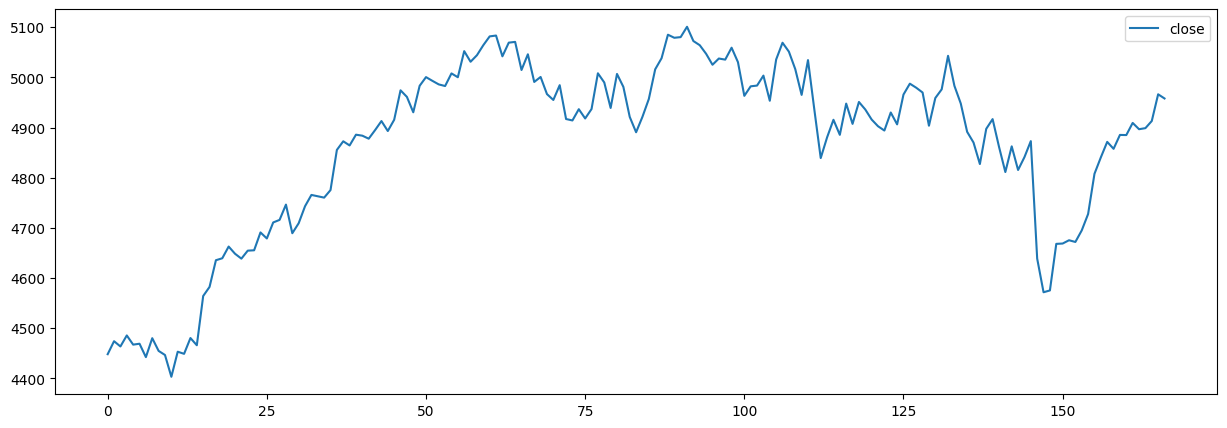

In [100]:
index_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3513, 8)


<Axes: >

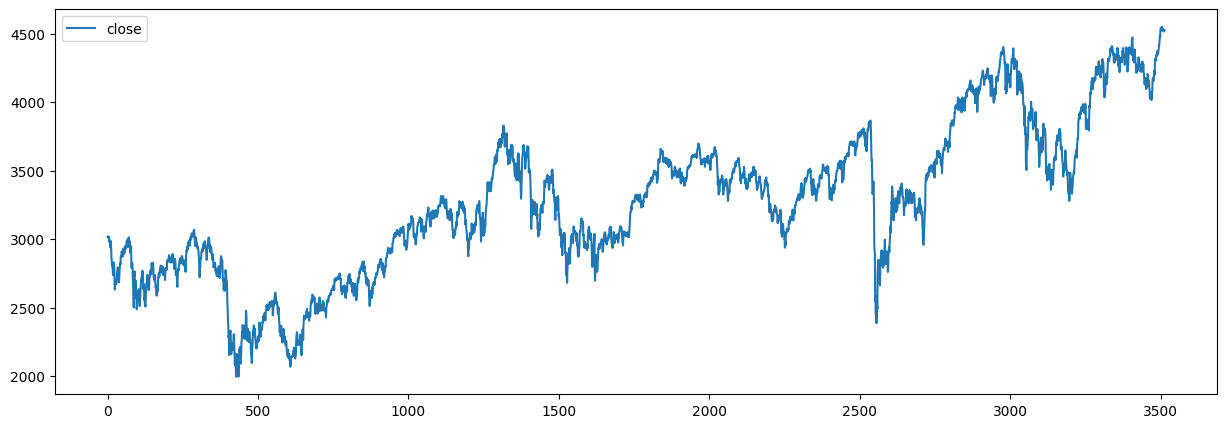

In [102]:
index_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

In [103]:
def DRL_prediction(model, environment, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    state_memory= []

    test_env.reset()
    max_steps = len(environment.df.index.unique()) - 1

    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        state_memory.append(test_obs[0])

        if (
            i == max_steps - 1
        ):  # more descriptive condition for early termination to clarify the logic
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0],state_memory

In [104]:
df_account_value_ppo_test, df_actions_ppo, states = DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)

hit end!


In [105]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

print(len(columns))

22


In [114]:
states = np.array(states)
z = pd.DataFrame(states,columns= columns)
z.head()

,acc_value,ADM,AZN,BA,BP,NOK,SAP,VOD,ADM_holding,AZN_holding,...,NOK_holding,SAP_holding,VOD_holding,ADM_ma,AZN_ma,BA_ma,BP_ma,NOK_ma,SAP_ma,VOD_ma
0,987373.5000,71.248657,66.875084,243.910004,34.646816,3.290370,147.933578,8.427602,18.0,0.0,...,0.0,22.0,0.0,71.645844,63.820744,243.725662,34.138023,3.242162,153.708771,8.354484
1,974955.1875,69.904167,67.325356,244.940002,34.415836,3.348606,146.679321,8.522722,36.0,0.0,...,0.0,44.0,0.0,71.585434,63.983559,244.633331,34.134171,3.237633,153.551422,8.355597
2,962566.8125,68.988342,66.933815,249.000000,34.675690,3.338900,147.992844,8.541746,54.0,0.0,...,0.0,66.0,0.0,71.490608,64.117332,245.657669,34.143475,3.234721,153.464172,8.359751
3,950044.3750,69.231911,67.746262,229.000000,34.098244,3.435961,150.669250,8.570282,72.0,0.0,...,0.0,88.0,0.0,71.384407,64.300056,245.960663,34.148609,3.235045,153.444427,8.362921
4,938036.5625,68.851944,67.452614,225.759995,33.578537,3.377724,150.264328,8.484674,90.0,0.0,...,0.0,110.0,0.0,71.266525,64.443947,246.152664,34.118774,3.232780,153.377274,8.356263


In [107]:
a2c_model = agent.get_model("a2c")
trained_a2c = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--------------------------------------
| time/                 |            |
|    fps                | 144        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -9.99      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -14.7      |
|    reward             | 0.05778634 |
|    std                | 1.01       |
|    value_loss         | 2.41       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 149       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000   

hit end!


<Axes: xlabel='date'>

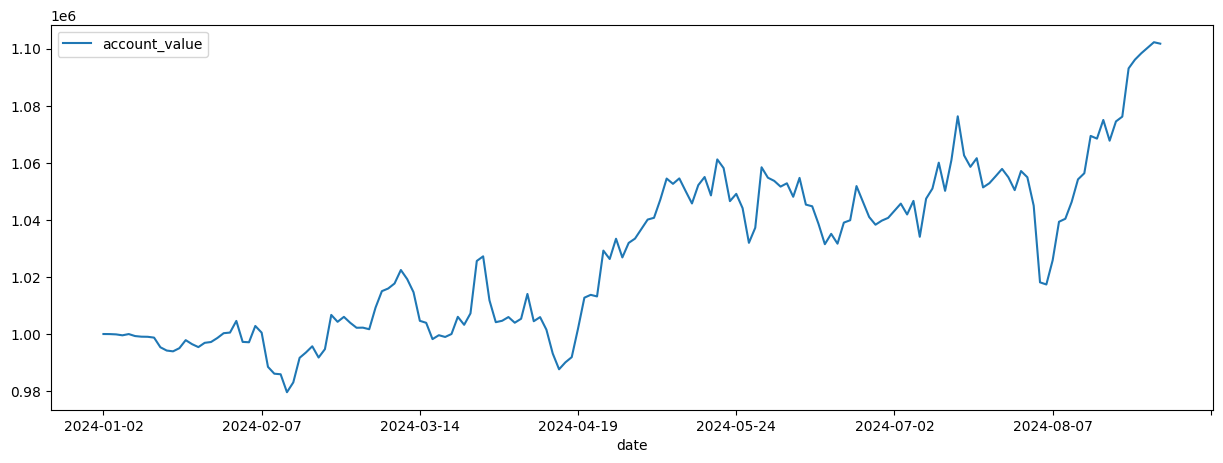

In [31]:

returns,actions = DRLAgent.DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot()

hit end!
day: 167, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1098160.60
total_reward: 98160.60
total_cost: 2630.14
total_trades: 705
Sharpe: 0.802
hit end!


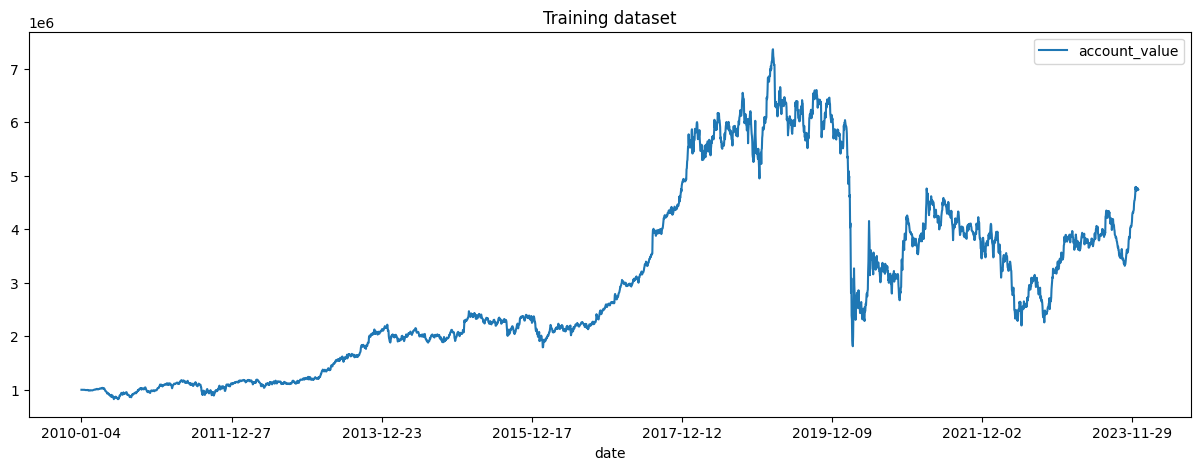

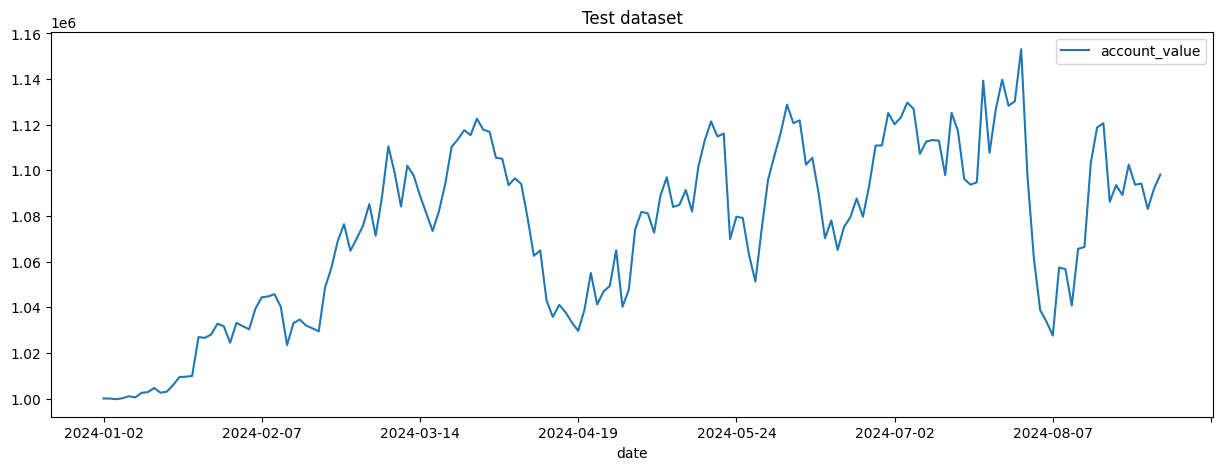

In [136]:
returns,actions,states = DRL_prediction(model=trained_a2c, 
                             environment=e_train_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot(title = 'Training dataset')
returns,actions,states_test = DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
ax = df_a2c.plot(title = 'Test dataset')